In [31]:
import os
import sys
from dotenv import load_dotenv

notebook_path = os.getcwd()

# One level up from the notebook
PROJECT_ROOT = os.path.abspath(os.path.join(notebook_path, "../"))

DATA_ROOT = os.path.join(PROJECT_ROOT, "data")

sys.path.insert(1, PROJECT_ROOT)
load_dotenv()

True

In [32]:
import glob

import databento as db
import pandas as pd
import numpy as np
import datetime

import plotly.graph_objects as go

In [33]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import re

Load saved Options price OHLCV and aggregate

In [34]:
symbol = "AAPL"
df = pd.read_csv(os.path.join(DATA_ROOT, "databento", f"{symbol}-options-ohlcv-1d.csv"), index_col=0)

df.index = pd.to_datetime(df.index, utc=True)
df['expiry_date'] = pd.to_datetime(df['expiry_date'], utc=True)

In [35]:
df.head()

rtype  publisher_id  instrument_id   open   high  \
ts_event                                                                      
2023-03-28 00:00:00+00:00     35            22       16778420   1.20   1.20   
2023-03-28 00:00:00+00:00     35            26       16778420   1.09   1.09   
2023-03-28 00:00:00+00:00     35            31       16778420   1.20   1.20   
2023-03-28 00:00:00+00:00     35            36       16778420   1.10   1.20   
2023-03-28 00:00:00+00:00     35            25           2117  19.00  19.00   

                             low  close  volume symbol_base  \
ts_event                                                      
2023-03-28 00:00:00+00:00   0.96   0.96      61        AAPL   
2023-03-28 00:00:00+00:00   1.09   1.09      38        AAPL   
2023-03-28 00:00:00+00:00   1.10   1.15     529        AAPL   
2023-03-28 00:00:00+00:00   1.10   1.20      51        AAPL   
2023-03-28 00:00:00+00:00  19.00  19.00       1        AAPL   

                                        expiry_date type  strike  
ts_event                                                          
2023-03-28 00:00:00+00:00 2023-04-21 00:00:00+00:00    P   146.0  
2023-03-28 00:00:00+00:00 2023-04-21 00:00:00+00:00    P   146.0  
2023-03-28 00:00:00+00:00 2023-04-21 00:00:00+00:00    P   146.0  
2023-03-28 00:00:00+00:00 2023-04-21 00:00:00+00:00    P   146.0  
2023-03-28 00:00:00+00:00 2025-12-19 00:00:00+00:00    C   200.0

Load saved Stock price OHLCV and aggregate

In [36]:
def read_df_with_prefix(directory, prefix):
    tmp = []

    for filename in glob.glob(os.path.join(directory, f"{prefix}*")):
        tmp.append(pd.read_csv(filename, index_col=0))

    return pd.concat(tmp, axis=0)

timeframe = "1d"

directory = os.path.join(DATA_ROOT, "databento")
prefix = f"{symbol.upper()}_ohlcv-1m_"

stock_df = read_df_with_prefix(directory, prefix)
stock_df.index = pd.to_datetime(stock_df.index)
stock_df = stock_df[['open','high','low','close','volume']]

start_time = '14:30'
end_time = '21:00'

agg_methods = {
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum',
}

tmp = stock_df.resample("1d").agg(agg_methods)
tmp = tmp.dropna() # non-trading days are na
trading_days = tmp.index

resampled_stock_df = stock_df.between_time(start_time, end_time).resample(timeframe).agg(agg_methods)
# aggregation creates non-trading dates. line below eliminates them.
resampled_stock_df = resampled_stock_df.loc[resampled_stock_df.index.strftime("%Y-%m-%d").isin(trading_days.strftime("%Y-%m-%d"))]

In [37]:
resampled_stock_df.loc['2024-01-01':'2024-01-07']

open    high      low   close    volume
ts_event                                                            
2024-01-02 00:00:00+00:00  187.18  188.43  183.890  185.60  22472204
2024-01-03 00:00:00+00:00  184.29  185.87  183.435  184.30  16005018
2024-01-04 00:00:00+00:00  182.13  183.08  180.880  181.90  17343193
2024-01-05 00:00:00+00:00  181.94  182.76  180.175  181.16  17229538

for option data aggregation below, may consider volume weighted mean for OHLC. but simple mean for now...

note: option need agg b/c even for one symbol, there are multiple data sources (see publisher csv)

In [38]:
agg_df = df[['type', 'strike', 'expiry_date', 'open', 'high', 'low', 'close', 'volume']].groupby(
    ['ts_event', 'type', 'strike', 'expiry_date']).agg({
        'open': 'mean',
        'high': 'mean',
        'low': 'mean',
        'close': 'mean',
        'volume': 'sum'
    })

tmp = []
for mi in agg_df.index:
    tmp.append(mi[3]-mi[0])

agg_df['time_to_expiry'] = tmp

agg_df = agg_df[:'2024-12-31'] # cut here bc stock data stops on 12/31/24

Load risk free rate data

In [39]:
rates_df = pd.read_csv(os.path.join(DATA_ROOT, 'rates.csv'))
rates_df['Effective Date'] = pd.to_datetime(rates_df['Effective Date'], utc=True)

In [40]:
rates_df

Effective Date Rate Type  Rate (%)  1st Percentile (%)  \
0     2025-02-04 00:00:00+00:00      EFFR      4.33                4.31   
1     2025-02-04 00:00:00+00:00      OBFR      4.33                4.25   
2     2025-02-04 00:00:00+00:00      TGCR      4.31                4.26   
3     2025-02-04 00:00:00+00:00      BGCR      4.31                4.26   
4     2025-02-04 00:00:00+00:00      SOFR      4.33                4.28   
...                         ...       ...       ...                 ...   
13550 2000-07-07 00:00:00+00:00      EFFR      6.42                 NaN   
13551 2000-07-06 00:00:00+00:00      EFFR      6.51                 NaN   
13552 2000-07-05 00:00:00+00:00      EFFR      6.52                 NaN   
13553 2000-07-03 00:00:00+00:00      EFFR      7.03                 NaN   
13554                       NaT       NaN       NaN                 NaN   

       25th Percentile (%)  75th Percentile (%)  99th Percentile (%)  \
0                     4.33                 4.34                 4.40   
1                     4.33                 4.33                 4.40   
2                     4.31                 4.32                 4.36   
3                     4.31                 4.32                 4.38   
4                     4.32                 4.38                 4.42   
...                    ...                  ...                  ...   
13550                  NaN                  NaN                  NaN   
13551                  NaN                  NaN                  NaN   
13552                  NaN                  NaN                  NaN   
13553                  NaN                  NaN                  NaN   
13554                  NaN                  NaN                  NaN   

       Volume ($Billions)  Target Rate From (%)  Target Rate To (%)  \
0                   104.0                  4.25                 4.5   
1                   281.0                   NaN                 NaN   
2                   894.0                   NaN                 NaN   
3                   909.0                   NaN                 NaN   
4                  2344.0                   NaN                 NaN   
...                   ...                   ...                 ...   
13550                 NaN                  6.50                 NaN   
13551                 NaN                  6.50                 NaN   
13552                 NaN                  6.50                 NaN   
13553                 NaN                  6.50                 NaN   
13554                 NaN                   NaN                 NaN   

       Intra Day - Low (%)  Intra Day - High (%)  Standard Deviation (%)  \
0                      NaN                   NaN                     NaN   
1                      NaN                   NaN                     NaN   
2                      NaN                   NaN                     NaN   
3                      NaN                   NaN                     NaN   
4                      NaN                   NaN                     NaN   
...                    ...                   ...                     ...   
13550                 6.00                  6.75                    0.12   
13551                 6.25                  8.00                    0.13   
13552                 2.00                  6.94                    0.50   
13553                 5.50                  7.50                    0.28   
13554                  NaN                   NaN                     NaN   

       30-Day Average SOFR  90-Day Average SOFR  180-Day Average SOFR  \
0                      NaN                  NaN                   NaN   
1                      NaN                  NaN                   NaN   
2                      NaN                  NaN                   NaN   
3                      NaN                  NaN                   NaN   
4                      NaN                  NaN                   NaN   
...                    ...                  ...

<Axes: xlabel='Effective Date'>

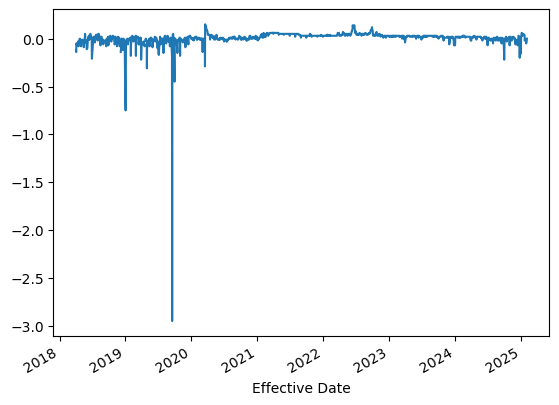

In [41]:
# SOFR starts in 2018 March. EFFR seems close enough for data before that.
dif = rates_df.groupby(['Rate Type', 'Effective Date']).first().loc['EFFR', 'Rate (%)'] - rates_df.groupby(['Rate Type', 'Effective Date']).first().loc['SOFR', 'Rate (%)']
dif.plot()

In [42]:
sofr_rates = rates_df.groupby(['Rate Type', 'Effective Date']).first().loc['SOFR', 'Rate (%)']
switch_day = sofr_rates.index[0]
effr_rates = rates_df.groupby(['Rate Type', 'Effective Date']).first().loc['EFFR'].loc[:switch_day - pd.Timedelta(days=1), 'Rate (%)']

In [43]:
risk_frees: pd.Series = pd.concat([effr_rates, sofr_rates])
dt = pd.date_range(risk_frees.index.min(), risk_frees.index.max(), freq='D')

rf_df = pd.DataFrame(index=dt, data=risk_frees)
rf_df['Rate (%)'] = rf_df['Rate (%)'].ffill()

merge stock price into option `agg_df`

In [44]:
firsts = agg_df.index.get_level_values('ts_event')
agg_df.loc[:, 'stock_close'] = resampled_stock_df.loc[firsts, 'close'].values
agg_df.loc[:, 'risk_free'] = (rf_df.loc[firsts, 'Rate (%)'] / 100).values
agg_df['time_to_expiry'] = agg_df['time_to_expiry'].apply(lambda x: x.days/365) # pd.Timedelta to number of years (float)

In [45]:
agg_df.head(20)

open  \
ts_event                  type strike expiry_date                           
2023-03-28 00:00:00+00:00 C    50.0   2023-03-31 00:00:00+00:00  107.3000   
                                      2023-04-21 00:00:00+00:00  106.3375   
                                      2024-01-19 00:00:00+00:00  108.4050   
                                      2025-01-17 00:00:00+00:00  109.3250   
                                      2025-12-19 00:00:00+00:00  110.9500   
                               55.0   2023-04-06 00:00:00+00:00  102.0500   
                               60.0   2023-03-31 00:00:00+00:00   97.3000   
                               65.0   2023-04-21 00:00:00+00:00   91.4500   
                               70.0   2023-04-06 00:00:00+00:00   86.6000   
                                      2023-04-21 00:00:00+00:00   87.4000   
                                      2024-01-19 00:00:00+00:00   89.5500   
                                      2025-06-20 00:00:00+00:00   93.0200   
                               80.0   2023-06-16 00:00:00+00:00   77.4700   
                                      2024-06-21 00:00:00+00:00   81.4700   
                               85.0   2023-06-16 00:00:00+00:00   73.8500   
                                      2023-07-21 00:00:00+00:00   74.3200   
                               90.0   2023-06-16 00:00:00+00:00   67.1000   
                                      2023-12-15 00:00:00+00:00   70.2500   
                                      2024-01-19 00:00:00+00:00   70.8100   
                                      2025-01-17 00:00:00+00:00   75.9000   

                                                                     high  \
ts_event                  type strike expiry_date                           
2023-03-28 00:00:00+00:00 C    50.0   2023-03-31 00:00:00+00:00  107.3000   
                                      2023-04-21 00:00:00+00:00  106.3375   
                                      2024-01-19 00:00:00+00:00  108.4050   
                                      2025-01-17 00:00:00+00:00  109.3250   
                                      2025-12-19 00:00:00+00:00  110.9500   
                               55.0   2023-04-06 00:00:00+00:00  102.0500   
                               60.0   2023-03-31 00:00:00+00:00   97.3000   
                               65.0   2023-04-21 00:00:00+00:00   91.4500   
                               70.0   2023-04-06 00:00:00+00:00   86.6000   
                                      2023-04-21 00:00:00+00:00   87.4000   
                                      2024-01-19 00:00:00+00:00   89.5500   
                                      2025-06-20 00:00:00+00:00   93.0200   
                               80.0   2023-06-16 00:00:00+00:00   77.4700   
                                      2024-06-21 00:00:00+00:00   81.4700   
                               85.0   2023-06-16 00:00:00+00:00   73.8500   
                                      2023-07-21 00:00:00+00:00   74.3200   
                               90.0   2023-06-16 00:00:00+00:00   67.1600   
                                      2023-12-15 00:00:00+00:00   70.2500   
                                      2024-01-19 00:00:00+00:00   70.8100   
                                      2025-01-17 00:00:00+00:00   75.9100   

                                                                     low  \
ts_event                  type strike expiry_date                          
2023-03-28 00:00:00+00:00 C    50.0   2023-03-31 00:00:00+00:00  107.300   
                                      2023-04-21 00:00:00+00:00  106.275   
                                      2024-01-19 00:00:00+00:00  108.405   
                                      2025-01-17 00:00:00+00:00  109.325   
                                      2025-12-19 00:00:00+00:00  110.950   
                               55.0   2023-04-06 00:00:00+00:00  102.050   
                               60.0   2023-03-31 00:00:00+00:00   97.30

In [46]:
agg_df = agg_df[['close', 'stock_close', 'time_to_expiry', 'risk_free']].rename(columns={'close': 'option_close'})
agg_df = agg_df.reset_index()

In [47]:
agg_df.head(5)

ts_event type  strike               expiry_date  \
0 2023-03-28 00:00:00+00:00    C    50.0 2023-03-31 00:00:00+00:00   
1 2023-03-28 00:00:00+00:00    C    50.0 2023-04-21 00:00:00+00:00   
2 2023-03-28 00:00:00+00:00    C    50.0 2024-01-19 00:00:00+00:00   
3 2023-03-28 00:00:00+00:00    C    50.0 2025-01-17 00:00:00+00:00   
4 2023-03-28 00:00:00+00:00    C    50.0 2025-12-19 00:00:00+00:00   

   option_close  stock_close  time_to_expiry  risk_free  
0       107.300       157.63        0.008219     0.0484  
1       106.275       157.63        0.065753     0.0484  
2       108.405       157.63        0.813699     0.0484  
3       109.325       157.63        1.810959     0.0484  
4       110.950       157.63        2.731507     0.0484

In [48]:
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks.analytical import vega

In [49]:
def implied_vol(S0, K, T, r, market_price, flag='C', tol=0.00001):
    max_iter = 200 #max number of iterations
    vol_old = 0.30 #initial guess

    for k in range(max_iter):
        bs_price = bs(flag.lower(), S0, K, T, r, vol_old)
        Cprime   = vega(flag.lower(), S0, K, T, r, vol_old) * 100
        if np.isnan(vol_old): break
        # print(k, vol_old, Cprime)
        C = bs_price - market_price
        vol_new = vol_old - C/Cprime
        bs_new = bs(flag.lower(), S0, K, T, r, vol_new)

        if (abs(vol_old - vol_new) < tol or abs(bs_new - market_price) < tol):
            break
        vol_old = vol_new

    implied_vol = vol_old
    return implied_vol

In [50]:
# test if the function works
S0, K, T, r = 30, 28, 0.2, 0.025
market_price = 3.97
implied_vol_est = implied_vol(S0, K, T, r, market_price, flag='C')
print(f"Implied Volatility = {implied_vol_est:.3%}")

Implied Volatility = 53.816%


In [ ]:
agg_df['implied_volatility'] = agg_df.apply(lambda row: implied_vol(
        S0=row['stock_close'],
        K=row['strike'],
        T=row['time_to_expiry'],
        r=row['risk_free'],  # Get risk-free rate by expiry date
        market_price=row['option_close'],
        flag=row['type']
), axis=1)

In [52]:
agg_df

ts_event type  strike               expiry_date  \
0      2023-03-28 00:00:00+00:00    C    50.0 2023-03-31 00:00:00+00:00   
1      2023-03-28 00:00:00+00:00    C    50.0 2023-04-21 00:00:00+00:00   
2      2023-03-28 00:00:00+00:00    C    50.0 2024-01-19 00:00:00+00:00   
3      2023-03-28 00:00:00+00:00    C    50.0 2025-01-17 00:00:00+00:00   
4      2023-03-28 00:00:00+00:00    C    50.0 2025-12-19 00:00:00+00:00   
...                          ...  ...     ...                       ...   
462270 2024-12-31 00:00:00+00:00    P   320.0 2025-06-20 00:00:00+00:00   
462271 2024-12-31 00:00:00+00:00    P   330.0 2027-01-15 00:00:00+00:00   
462272 2024-12-31 00:00:00+00:00    P   350.0 2025-03-21 00:00:00+00:00   
462273 2024-12-31 00:00:00+00:00    P   370.0 2025-01-17 00:00:00+00:00   
462274 2024-12-31 00:00:00+00:00    P   370.0 2026-06-18 00:00:00+00:00   

        option_close  stock_close  time_to_expiry  risk_free  \
0            107.300       157.63        0.008219     0.0484   
1            106.275       157.63        0.065753     0.0484   
2            108.405       157.63        0.813699     0.0484   
3            109.325       157.63        1.810959     0.0484   
4            110.950       157.63        2.731507     0.0484   
...              ...          ...             ...        ...   
462270        68.810       250.42        0.468493     0.0449   
462271        79.000       250.42        2.041096     0.0449   
462272        97.800       250.42        0.219178     0.0449   
462273       117.775       250.42        0.046575     0.0449   
462274       118.675       250.42        1.463014     0.0449   

        implied_volatility  
0                      NaN  
1                      NaN  
2                      NaN  
3                      NaN  
4                      NaN  
...                    ...  
462270            0.341947  
462271            0.319253  
462272            0.450333  
462273                 NaN  
462274            0.414354  

[462275 rows x 9 columns]

In [53]:
agg_df.to_csv(os.path.join(DATA_ROOT, "option_iv", f"{symbol}-iv-1d.csv"))